In [1]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torchvision
from DLBio.pytorch_helpers import get_device

import numpy as np
import matplotlib.pyplot as plt
import ds_ear_siamese
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# Set Up All Configurations here
class Config():
    dataset_dir = '../dataset_low_res/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 100
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 1

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
test_indices = rand_indices[n_70:]

# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform? 
    data_path=Config.dataset_dir
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

['alissa_buh', 'falco_len', 'gregor_spi', 'janna_qua', 'jesse_kru', 'johannes_boe', 'johannes_wie', 'konrad_von', 'mila_wol', 'nils_loo', 'sarah_feh', 'tim_moe']
847


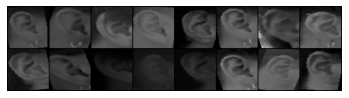

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
model = mobilenet_v2(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#model.features[0][0] = nn.ReflectionPad2d(1)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)
#model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss()
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


Epoch number 0
 Current loss 0.998358428478241

Epoch number 0
 Current loss 0.9093360900878906

Epoch number 1
 Current loss 1.1163251399993896

Epoch number 1
 Current loss 0.7520779371261597

Epoch number 2
 Current loss 1.0945277214050293

Epoch number 2
 Current loss 1.3640096187591553

Epoch number 3
 Current loss 0.7765389680862427

Epoch number 3
 Current loss 0.7772322297096252

Epoch number 4
 Current loss 0.6316981315612793

Epoch number 4
 Current loss 0.7036733627319336

Epoch number 5
 Current loss 0.6235232353210449

Epoch number 5
 Current loss 0.56725013256073

Epoch number 6
 Current loss 0.605097770690918

Epoch number 6
 Current loss 0.3129494786262512

Epoch number 7
 Current loss 0.36943671107292175

Epoch number 7
 Current loss 0.35738441348075867

Epoch number 8
 Current loss 0.3069058656692505

Epoch number 8
 Current loss 0.42017415165901184

Epoch number 9
 Current loss 0.5037742853164673

Epoch number 9
 Current loss 0.4124053716659546

Epoch number 10
 Curr

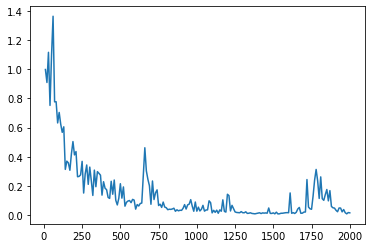

In [7]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [10]:
#Output for NN
# def generate_output( img_in, img_in2):
#     if cuda.is_available():
#         return model(Variable(img_in).cuda(), Variable(img_in2).cuda())
#     else:
#         return model(Variable(img_in), Variable(img_in2))

# Output for Mobilenet
def generate_output( img_in):
    if cuda.is_available():
        return model(Variable(img_in).cuda())
    else:
        return model(Variable(img_in))         

In [16]:
iter_batches = iter(test_dataloader)

accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    # NEED TO BE CHANGED FOR MOBILENET
    # match_out1, match_out2 = generate_output(m[0], m[1])
    # non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    match_out1 = generate_output(m[0])
    match_out2 = generate_output(m[1])                 
    non_match_out1 = generate_output(n[0])
    non_match_out2 = generate_output(n[1])
    
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < euclidean_distance_pn): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format(accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.390
pos-neg:     1.074
Acc. count:  1 

pos-pos:     1.008
pos-neg:     0.768
Acc. count:  1 

pos-pos:     0.569
pos-neg:     0.898
Acc. count:  2 

pos-pos:     0.177
pos-neg:     0.880
Acc. count:  3 

pos-pos:     0.970
pos-neg:     1.099
Acc. count:  4 

pos-pos:     0.389
pos-neg:     1.012
Acc. count:  5 

pos-pos:     0.696
pos-neg:     0.848
Acc. count:  6 

pos-pos:     0.501
pos-neg:     1.016
Acc. count:  7 

pos-pos:     0.516
pos-neg:     0.592
Acc. count:  8 

pos-pos:     0.643
pos-neg:     1.253
Acc. count:  9 

pos-pos:     0.625
pos-neg:     0.712
Acc. count:  10 

pos-pos:     0.382
pos-neg:     1.026
Acc. count:  11 

pos-pos:     0.347
pos-neg:     0.729
Acc. count:  12 

pos-pos:     0.505
pos-neg:     0.940
Acc. count:  13 

pos-pos:     0.739
pos-neg:     1.336
Acc. count:  14 

pos-pos:     0.663
pos-neg:     1.143
Acc. count:  15 

pos-pos:     0.498
pos-neg:     0.304
Acc. count:  15 

pos-pos:     0.473
pos-neg:     0.819
Acc. count:  16 

po

In [12]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [17]:
#torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model_mobile_low.pt')